This notebook is designed for the multiclass image classification of paintings. The model developed is expected to classify paintings into ten different genres

**Created by Zidny Yasrah Sallum**

> Dataset Link : https://www.kaggle.com/datasets/jaafaryassine/painter-by-numbers

# **1. Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import regularizers

# **2 Data Loading**

In [ ]:
drive.mount('/content/gdrive')
files.upload()

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zidnyyasrah","key":"4b2305378e4b3bb3ea4eeda3c536f9b3"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Dec 19 02:41 kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d jaafaryassine/painter-by-numbers

100% 2.24G/2.24G [02:02<00:00, 21.7MB/s]
100% 2.24G/2.24G [02:02<00:00, 19.6MB/s]


In [ ]:
!unzip painter-by-numbers.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/955.jpg          
  inflating: images/9550.jpg         
  inflating: images/95500.jpg        
  inflating: images/95501.jpg        
  inflating: images/95502.jpg        
  inflating: images/95503.jpg        
  inflating: images/95504.jpg        
  inflating: images/95505.jpg        
  inflating: images/95506.jpg        
  inflating: images/95507.jpg        
  inflating: images/95508.jpg        
  inflating: images/95509.jpg        
  inflating: images/9551.jpg         
  inflating: images/95510.jpg        
  inflating: images/95511.jpg        
  inflating: images/95512.jpg        
  inflating: images/95513.jpg        
  inflating: images/95514.jpg        
  inflating: images/95515.jpg        
  inflating: images/95516.jpg        
  inflating: images/95517.jpg        
  inflating: images/95518.jpg        
  inflating: images/95519.jpg        
  inflating: images/9552.jpg         
  inflating: images/95520.jpg        

In [ ]:
df = pd.read_csv('imagesinfo.csv')

df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,836.jpg


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103250 entries, 0 to 103249
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   artist      103250 non-null  object 
 1   date        76887 non-null   object 
 2   genre       101996 non-null  object 
 3   pixelsx     103250 non-null  float64
 4   pixelsy     103250 non-null  float64
 5   size_bytes  103250 non-null  float64
 6   source      103083 non-null  object 
 7   style       102264 non-null  object 
 8   title       103128 non-null  object 
 9   filename    103250 non-null  object 
dtypes: float64(3), object(7)
memory usage: 7.9+ MB


# **3. Feature Engineering**

## **Feature Selection**

In [ ]:
df = df.drop(['artist','pixelsx','pixelsy','size_bytes','source','title','date','style'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103250 entries, 0 to 103249
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   genre     101996 non-null  object
 1   filename  103250 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


## **Missing Values**

In [ ]:
df.isnull().sum()

genre       1254
filename       0
dtype: int64

It seems that there are some missing values in the dataset, we need to get rid of them

In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

genre       0
filename    0
dtype: int64

In [ ]:
df.head()

,genre,filename
0,abstract,102257.jpg
1,abstract,75232.jpg
5,mythological painting,29855.jpg
6,abstract,62252.jpg
7,bird-and-flower painting,49823.jpg


In [ ]:
print(df['genre'].unique())
print('class label: ', df['genre'].nunique())

['abstract' 'mythological painting' 'bird-and-flower painting' 'cityscape'
 'landscape' 'religious painting' 'marina' 'genre painting'
 'history painting' 'still life' 'animal painting' 'self-portrait'
 'illustration' 'allegorical painting' 'literary painting'
 'flower painting' 'portrait' 'figurative' 'interior' 'nude painting (nu)'
 'poster' 'symbolic painting' 'advertisement' 'design' 'panorama'
 'sketch and study' 'cloudscape' 'quadratura' 'caricature' 'capriccio'
 'veduta' 'battle painting' 'calligraphy' 'vanitas' 'pastorale'
 'wildlife painting' 'miniature' 'yakusha-e' 'tessellation' 'shan shui'
 'bijinga' 'urushi-e']
class label:  42


In [ ]:
genre = df.copy()
class_counts = genre['genre'].value_counts()

# Display each class and the number of images
for class_label, count in class_counts.items():
    print(f"Class: {class_label}, Number of Images: {count}")
print('Number of classes: ',class_counts.nunique())

Class: portrait, Number of Images: 16847
Class: landscape, Number of Images: 15006
Class: genre painting, Number of Images: 14260
Class: abstract, Number of Images: 9498
Class: religious painting, Number of Images: 7429
Class: cityscape, Number of Images: 5348
Class: sketch and study, Number of Images: 3644
Class: illustration, Number of Images: 3202
Class: still life, Number of Images: 3132
Class: symbolic painting, Number of Images: 2545
Class: nude painting (nu), Number of Images: 2290
Class: figurative, Number of Images: 2244
Class: design, Number of Images: 2024
Class: mythological painting, Number of Images: 1910
Class: marina, Number of Images: 1805
Class: flower painting, Number of Images: 1606
Class: animal painting, Number of Images: 1571
Class: self-portrait, Number of Images: 1531
Class: allegorical painting, Number of Images: 1034
Class: history painting, Number of Images: 879
Class: interior, Number of Images: 670
Class: literary painting, Number of Images: 558
Class: bat

There are many classes with a very limited number of images, we can limit the number of classes to the top 10 based on the highest number of images

In [ ]:
# Calculate the count of images per class
class_counts = genre['genre'].value_counts()

# Identify the 5 classes with the lowest counts
low_count_classes = class_counts.nsmallest(29).index
genres_to_remove = ['genre painting','still life','cityscape']

# Filter your data to exclude rows associated with the 5 classes with the lowest counts
genre_final = genre[~genre['genre'].isin(low_count_classes)]

# Further filter to exclude 'genre painting'
genre_final = genre_final[~genre_final['genre'].isin(genres_to_remove)]

# Display information about the classes and their counts after filtering
print("Classes and their counts after filtering:")
print(genre_final['genre'].value_counts())
print("Number of unique classes:", genre_final['genre'].nunique())


Classes and their counts after filtering:
portrait              16847
landscape             15006
abstract               9498
religious painting     7429
sketch and study       3644
illustration           3202
symbolic painting      2545
nude painting (nu)     2290
figurative             2244
design                 2024
Name: genre, dtype: int64
Number of unique classes: 10


Since the dataset is highly unbalanced, we can also limit the number of images to a maximum of 5000

In [ ]:
# Define a function to randomly select rows for each category
def limit_category(group):
  if len(group) > 5000:
    return group.sample(5000, random_state=1)
  else:
    return group

# Apply the function to each group (category)
genre_finall = genre_final.groupby('genre', group_keys=False).apply(limit_category)

# Reset the index of the limited DataFrame
genre_finall.reset_index(drop=True, inplace=True)

print(genre_finall['genre'].value_counts())

abstract              5000
landscape             5000
portrait              5000
religious painting    5000
sketch and study      3644
illustration          3202
symbolic painting     2545
nude painting (nu)    2290
figurative            2244
design                2024
Name: genre, dtype: int64


## **Splitting Data**

In [ ]:
train_data, temp_data = train_test_split(genre_finall, test_size=0.2, random_state=0)

val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=0)

In [ ]:
source_folder = '/content/images/'

# Training set
for index, row in train_data.iterrows():
    filename = row['filename']
    label = row['genre']

    target_folder = os.path.join('/content/genre/train/', f'{label}')
    os.makedirs(target_folder, exist_ok=True)

    try:
        source_path = os.path.join(source_folder, filename)
        target_path = os.path.join(target_folder, filename)
        shutil.move(source_path, target_path)
    except FileNotFoundError:
        print(f" '{filename}' not found.")

In [ ]:
# Validation set
for index, row in val_data.iterrows():
    filename = row['filename']
    label = row['genre']

    target_folder = os.path.join('/content/genre/val/', f'{label}')
    os.makedirs(target_folder, exist_ok=True)

    try:
        source_path = os.path.join(source_folder, filename)
        target_path = os.path.join(target_folder, filename)
        shutil.move(source_path, target_path)
    except FileNotFoundError:
        print(f" '{filename}' not found.")

In [ ]:
# Testing set
for index, row in test_data.iterrows():
    filename = row['filename']
    label = row['genre']

    target_folder = os.path.join('/content/genre/test/', f'{label}')
    os.makedirs(target_folder, exist_ok=True)

    try:
        source_path = os.path.join(source_folder, filename)
        target_path = os.path.join(target_folder, filename)
        shutil.move(source_path, target_path)

    except FileNotFoundError:
        print(f" '{filename}' not found.")

In [ ]:
path = "/content/genre/train"
files = os.listdir(path)
genre_classes = len(files)
print('total genre class: ',genre_classes)

total genre class:  10


# **4. Image Preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    )

val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_data_dir = '/content/genre/train'
img_width, img_height = 224, 224
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 28759 images belonging to 10 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(
    '/content/genre/val/',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

Found 3595 images belonging to 10 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    '/content/genre/test/',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

Found 3595 images belonging to 10 classes.


# **5. Model Definition**

In [ ]:
# Inception V3
base_model = InceptionV3(input_shape=(img_width, img_height, 3), include_top=False)

for layer in base_model.layers:
  layer.trainable = False

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
model = Sequential()
model.add(base_model)

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'))

model.add(Flatten())

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(genre_classes, activation='softmax'))

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,decay_steps=10000,decay_rate=0.9,staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 5, 5, 256)         4718848   
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 256)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_95 (Conv2D)          (None, 2, 2, 128)         295040    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 1, 128)         0         
 g2D)                                                   

# **6. Model Training**

In [ ]:
epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stop])

Epoch 1/50
899/899 [==============================] - 551s 598ms/step - loss: 2.3462 - accuracy: 0.4378 - val_loss: 1.5979 - val_accuracy: 0.5143
Epoch 2/50
899/899 [==============================] - 535s 595ms/step - loss: 1.6157 - accuracy: 0.5021 - val_loss: 1.5030 - val_accuracy: 0.5394
Epoch 3/50
899/899 [==============================] - 540s 601ms/step - loss: 1.5538 - accuracy: 0.5305 - val_loss: 1.4766 - val_accuracy: 0.5602
Epoch 4/50
899/899 [==============================] - 547s 608ms/step - loss: 1.5080 - accuracy: 0.5470 - val_loss: 1.4504 - val_accuracy: 0.5583
Epoch 5/50
899/899 [==============================] - 536s 596ms/step - loss: 1.4851 - accuracy: 0.5538 - val_loss: 1.4505 - val_accuracy: 0.5688
Epoch 6/50
899/899 [==============================] - 542s 603ms/step - loss: 1.4686 - accuracy: 0.5563 - val_loss: 1.4131 - val_accuracy: 0.5755
Epoch 7/50
899/899 [==============================] - 540s 601ms/step - loss: 1.4511 - accuracy: 0.5656 - val_loss: 1.4030 -

# **7. Model Evaluation**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

113/113 [==============================] - 11s 96ms/step - loss: 1.3222 - accuracy: 0.6095
Test Accuracy: 60.95%


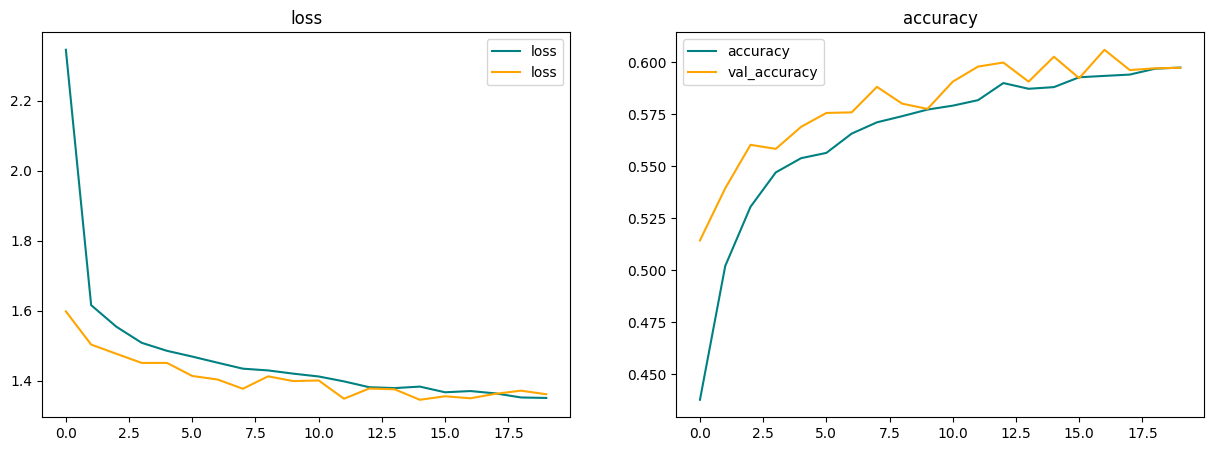

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='loss')
plt.title('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('accuracy')
plt.legend()
plt.show()

# **8. Model Saving**

In [ ]:
model.save('/content/genre_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/drive/MyDrive/genre_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **9. Model Inference**

In [ ]:
from google.colab import files
from PIL import Image
import io

In [ ]:
model = tf.keras.models.load_model('/content/genre_model.h5')

Saving Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg to Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg


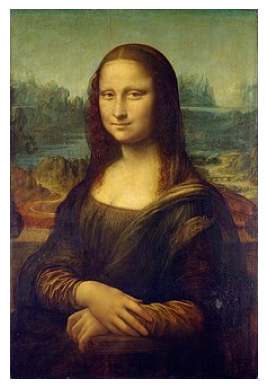

In [ ]:
uploaded_image = files.upload()

# Assuming only one image is uploaded
img_path = list(uploaded_image.keys())[0]

# Open the image using Pillow
img = Image.open(io.BytesIO(uploaded_image[img_path]))

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
# Load n preprocess
img_path = list(uploaded_image.keys())[0]
img = Image.open(img_path)
img = img.resize((224, 224))
img_array = np.asarray(img)
img_array = img_array / 255.0  # Normalize pixel
img_array = np.expand_dims(img_array, axis=0)


predictions = model.predict(img_array)

1/1 [==============================] - 4s 4s/step


In [ ]:
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)

# Reverse the mapping to get class labels
class_labels = dict((v, k) for k, v in class_indices.items())
print("Class Labels:", class_labels)

# Find the predicted class label
predicted_class_index = np.argmax(predictions)
print("Predicted Class Index:", predicted_class_index)

# Print the class labels to see what keys are present
print("Class Labels Keys:", class_labels.keys())

# Check if the predicted class index exists in the class labels dictionary
if predicted_class_index in class_labels:
    predicted_class_label = class_labels[predicted_class_index]
    print(f"The predicted class is: {predicted_class_label}")
else:
    print(f"Error: Predicted class index {predicted_class_index} not found in class labels.")

Class Indices: {'abstract': 0, 'design': 1, 'figurative': 2, 'illustration': 3, 'landscape': 4, 'nude painting (nu)': 5, 'portrait': 6, 'religious painting': 7, 'sketch and study': 8, 'symbolic painting': 9}
Class Labels: {0: 'abstract', 1: 'design', 2: 'figurative', 3: 'illustration', 4: 'landscape', 5: 'nude painting (nu)', 6: 'portrait', 7: 'religious painting', 8: 'sketch and study', 9: 'symbolic painting'}
Predicted Class Index: 6
Class Labels Keys: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
The predicted class is: portrait
